In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython.display import display, clear_output

In [2]:
(train_images_tmp, _),(_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images_tmp = train_images_tmp.reshape(train_images_tmp.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images_tmp - 127.5) / 127.5 # image normalization to [-1, 1]

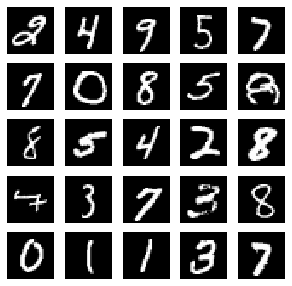

In [4]:
plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(train_images[np.random.randint(0,train_images.shape[0]),:,:,0],cmap='gray')

In [5]:
batch_size = 256
epoch = 100
z_dim = 128
gamma = 0.75
Lambda = 0.001
lr = 0.0002
beta1 = 0.5
kt = 0
num_batches = int(train_images.shape[0]/batch_size)

In [6]:
def make_disc():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='VALID'))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='VALID'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(7*7*32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7,7,32)))

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    
    model.add(tf.keras.layers.Conv2D(filters = 1, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'tanh'))
    
    return model

def make_gen():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(7*7*32))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7,7,32)))

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    
    model.add(tf.keras.layers.Conv2D(filters = 1, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'tanh'))

    return model

In [7]:
generator = make_gen()
discriminator = make_disc()

generator_optimizer = tf.keras.optimizers.Adam(lr,beta_1 = beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr,beta_1 = beta1)

In [8]:
kttot = [kt]
Mtot = []
Dlossmat = []
Glossmat = []
lrmat = []

Z_for_val = tf.random.uniform(shape = [25,z_dim], minval=-1, maxval=1)

In [9]:
start_time = time.time()
for e in range(epoch):
    start = time.time()
    for b in range(num_batches):
        batch_images = train_images[b*batch_size:(b+1)*batch_size,:,:,:]
        batch_z = tf.random.uniform(shape=[batch_size,z_dim],minval=-1,maxval=1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_latent = generator(batch_z,training=True)

            D_real_img = discriminator(batch_images,training=True)
            D_fake_img = discriminator(gen_latent,training=True)
            
            Dloss_real = tf.math.reduce_mean(tf.abs(batch_images-D_real_img))
            Dloss_fake = tf.math.reduce_mean(tf.abs(gen_latent-D_fake_img))
            
            Dloss = Dloss_real - kt*Dloss_fake
            Gloss = Dloss_fake
            
            gradients_of_discriminator = disc_tape.gradient(Dloss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            gradients_of_generator = gen_tape.gradient(Gloss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            
        M = Dloss_real + tf.abs(gamma*Dloss_real - Dloss_fake)
        Mtot = np.append(Mtot,[M],axis=0)
        
        kt=tf.clip_by_value(kt+Lambda*(gamma*Dloss_real-Dloss_fake),0,1)
        kttot = np.append(kttot,[kt],axis=0)
        
        Dlossmat = np.append(Dlossmat,[Dloss],axis=0)
        Glossmat = np.append(Glossmat,[Gloss],axis=0)
        lrmat = np.append(lrmat,[lr],axis=0)

        print(f'Epoch : {e+1}', f'batch number : {b+1}', f'Iter : {e*num_batches + (b+1)}', f'Dloss : {Dloss}', f'Gloss : {Gloss}', f'kt : {kt}', f'M : {M}', f'lr : {lr}')
        clear_output(wait=True)

end_time = time.time()
print("Training Done")
print("training time", end_time-start_time)

Training Done
training time 2023.9158489704132


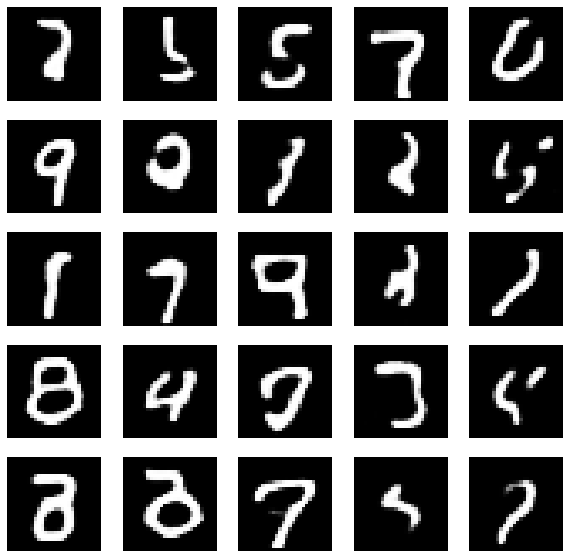

In [10]:
testnoise = tf.random.uniform(shape=[25,z_dim], minval=-1, maxval=1)
testresult = discriminator(generator(testnoise,training=False),training=False)

Fig= plt.figure(figsize=(10,10))

for p in range(25):
    MF = Fig.add_subplot(5,5,p+1)
    MF.imshow(testresult[p,:,:,0],cmap='gray')
    plt.axis('off')

Text(0, 0.5, 'learning rate')

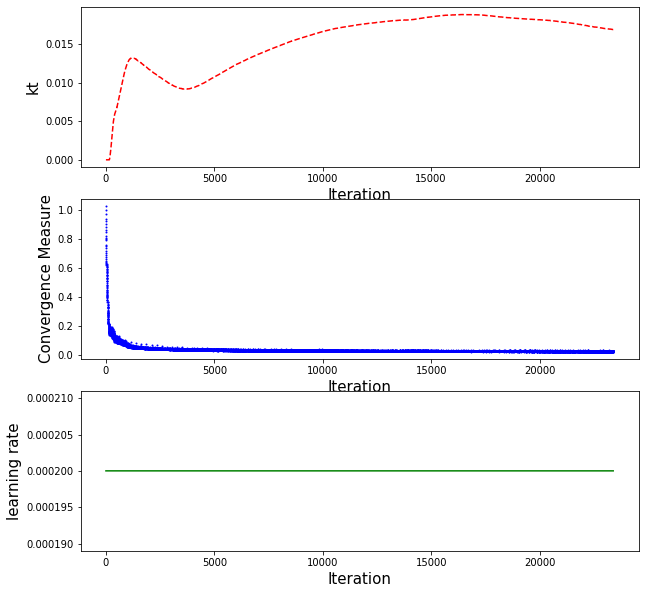

In [11]:
Figkm = plt.figure(figsize=(10,10))
axkm1 = Figkm.add_subplot(3,1,1)
axkm1.plot(kttot[:],'r--')
axkm1.set_xlabel('Iteration', Fontsize = 15)
axkm1.set_ylabel('kt',Fontsize=15)
axkm2 = Figkm.add_subplot(3,1,2)
axkm2.plot(Mtot[:],'b.',Markersize=2)
axkm2.set_xlabel('Iteration', Fontsize = 15)
axkm2.set_ylabel('Convergence Measure',Fontsize=15)
axkm2 = Figkm.add_subplot(3,1,3)
axkm2.plot(lrmat[:],'g',Markersize=2)
axkm2.set_xlabel('Iteration', Fontsize = 15)
axkm2.set_ylabel('learning rate',Fontsize=15)

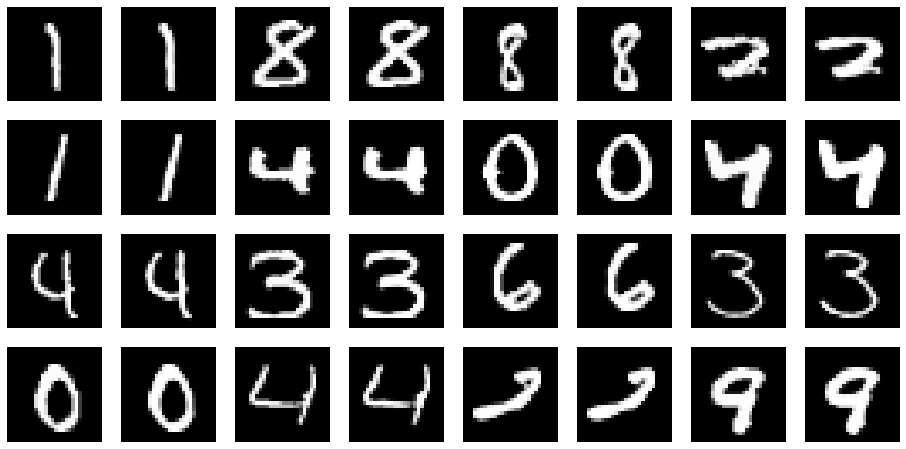

In [12]:
disc_testnum = np.random.choice(train_images.shape[0],16,replace=False)
disctest = train_images[disc_testnum,:,:,:]

disc_pic = discriminator(disctest,training=False)

figdisc= plt.figure(figsize=(16,8))
for dts in range(32):
    dtf = figdisc.add_subplot(4,8,dts+1)
    if dts%2 == 0:
        dtf.imshow(disctest[int(dts/2),:,:,0],cmap='gray')
    elif dts%2 == 1:
        dtf.imshow(disc_pic[int((dts)/2),:,:,0],cmap='gray')            
    plt.axis('off')
    

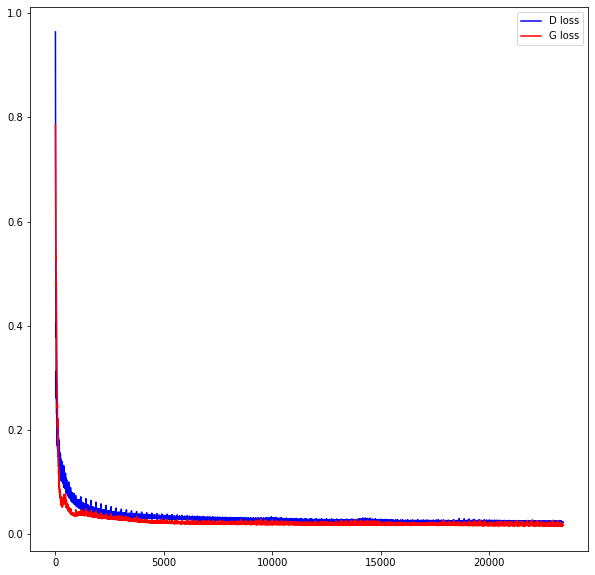

In [13]:
figdg = plt.figure(figsize = (10,10))
axdg = figdg.add_subplot(1,1,1)
axdg.plot(Dlossmat[:],'b')
axdg.plot(Glossmat[:],'r')
axdg.legend(['D loss', 'G loss'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



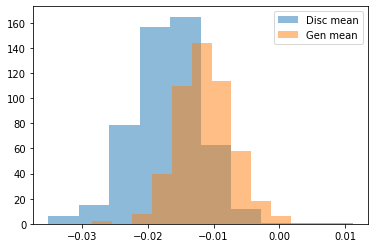

In [14]:
pickmean = np.random.choice(train_images.shape[0],500,replace=False)
disc_meantest = train_images[pickmean,:,:,:]-discriminator(train_images[pickmean,:,:,:],training=False)

latentmean = np.random.uniform(low=-1, high=1, size=[500,z_dim])
gen_mean_tmp = generator(latentmean,training=False)
gen_meantest = gen_mean_tmp-discriminator(gen_mean_tmp,training=False)

disc_mean = np.mean(np.mean(np.mean(disc_meantest,axis = 1),axis=1),axis=1)
gen_mean = np.mean(np.mean(np.mean(gen_meantest,axis = 1),axis=1),axis=1)
#plt.plot(disc_mean,'b.')
#plt.plot(gen_mean,'r.')
plt.hist(disc_mean, alpha=0.5)
plt.hist(gen_mean, alpha=0.5)
plt.legend(['Disc mean','Gen mean'])

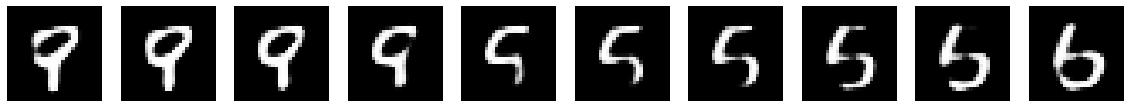

In [15]:
samp_num = 10
lat_for_interp1 = np.random.uniform(low=-1,high=1,size=[1,z_dim])
lat_for_interp2 = np.random.uniform(low=-1,high=1,size=[1,z_dim])

interp_tmp = np.linspace(0,1,num=samp_num)

for i in interp_tmp:
    L = (1-i)*lat_for_interp1 + i*lat_for_interp2
    if i==0:
        Latmat = L
    else:
        Latmat = np.append(Latmat,L,axis=0)
        
int_image = generator(Latmat,training=False)

intfig= plt.figure(figsize=(20,25))

for ipnum in range(samp_num):
    intsubp = intfig.add_subplot(1,samp_num,ipnum+1)
    intsubp.imshow(int_image[ipnum,:,:,0],cmap='gray')
    plt.axis('off')